In [1]:
import shutil
import sys
import os
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ultralytics import YOLO
import ultralytics
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import matplotlib.ticker as ticker
import warnings
import random
import seaborn as sns
import csv
import datetime

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
from tensorflow.keras.layers import *


import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

E0000 00:00:1749913179.332951  956690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749913179.338177  956690 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


device(type='cuda')

In [3]:
def create_num_to_label():
    with open("IP102/ip102_v1.1/num_label_reduced.txt") as f:
        num_to_label = {}
        for text in f.read().split("\n"):
            n,l = text.split(' ',1);
            num_to_label[n] = l.strip()

    return num_to_label

num_to_label = create_num_to_label()

def create_name_to_num():
    with open("IP102/ip102_v1.1/name_num_table.txt") as f:
        name_to_num = [] # class data
        for l in f.read().split("\n"):
            v = tuple(l.split())
            if v:
                if str(int(v[1])+1) in num_to_label.keys():
                    v = [v[0],str(int(v[1])+1)] # to fit the format in num_to_label.txt
                    name_to_num.append(v)
    
    return np.array(name_to_num)

name_to_num = create_name_to_num()

In [4]:
original_DA_num_to_label = {23:"corn borer", 52:"blister beetle"} # original num_to_label

DA_label_to_num = {"corn borer":0, "blister beetle":1} # num_to_label for CGAN

def assign_augment_img(name_to_num):
    DA_path_to_num = []
    src_directory = "IP102/ip102_v1.1/images/"
    for name, num in zip(name_to_num[:, 0], name_to_num[:, 1]):
        num = int(num)
        if num in np.array(list(original_DA_num_to_label.keys())):
            DA_path_to_num.append([src_directory + name, DA_label_to_num[original_DA_num_to_label[num]]])

    return np.array(DA_path_to_num)


DA_path_to_num = assign_augment_img(name_to_num)
print(len(DA_path_to_num))

3595


In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

batch_size = 64

img_size = 128
epoch_count = 200
noise_dim = 100 
n_class = 2

tags = list(DA_label_to_num.keys())

# Sample data
image_paths = DA_path_to_num[:,0]
labels = DA_path_to_num[:,1]

# Load images and labels
X_train = []
y_train = []

for path, label in zip(image_paths, labels):
    img = load_img(path, target_size=(img_size,img_size))
    img_array = img_to_array(img)
    X_train.append(img_array)
    y_train.append(label)

X_train = np.array(X_train).astype("float32") / 255.0

# Encode string labels into integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = np.array(y_train)

X_train = (X_train - 127.5) / 127.5
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

def data_generator():
    for x, y in zip(X_train, y_train):
        yield x, y

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=X_train.shape[1:], dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)  # adjust if y is not scalar
    )
)

dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)

In [16]:
print(dataset)
print("-------images---------")
print(f"Data Amount: {len(X_train)}")
print(f"Image Size : {len(X_train[0])} x {len(X_train[0,0])}")
print(f"Channel    : {len(X_train[0,0,0])}")
print(f"Shape      : {X_train.shape}")

print("-------labels---------")
print(f"Data Amount: {len(y_train)}")
print(f"Shape      : {y_train.shape}")  

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>
-------images---------
Data Amount: 3595
Image Size : 128 x 128
Channel    : 3
Shape      : (3595, 128, 128, 3)
-------labels---------
Data Amount: 3595
Shape      : (3595,)


### CGAN with tensorflow

In [17]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real, fake): # real, contains labels predicted for real images. Similary fake.
    real_loss = bce_loss(tf.ones_like(real), real) # loss for real image; small is better
    fake_loss = bce_loss(tf.zeros_like(fake), fake)# loss for fake image; small is better
    total_loss = real_loss + fake_loss # sum
    return total_loss
  
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # loss for fake image; big is better
  
d_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5) # beta_1 is decay rate for momentum, set to 3
g_optimizer=Adam(learning_rate=0.0002, beta_1 = 0.5)

In [18]:
def build_generator():
    global img_size
    global n_class

    emb_d = 50
    srtd = 2
    convT_krn_s = 4
    qtr_s = int(img_size / (srtd**2))
    h1 = 128
    lrelu_alpha = 0.2
    conv_krn_s = 8
    

    in_label = Input(shape=(1,), name= "label_input") # 1 because of only one label for each image
    li = Embedding(n_class, emb_d)(in_label)

    n_nodes = qtr_s * qtr_s
    li = Dense(n_nodes)(li)
    li = Reshape((qtr_s, qtr_s, 1))(li)
    
    in_lat = Input(shape=(noise_dim,), name="noise_input")
    n_nodes =  qtr_s * qtr_s * h1
    gen = Dense(n_nodes, activation=LeakyReLU(alpha=lrelu_alpha))(in_lat)
    gen = Reshape((qtr_s, qtr_s, h1))(gen)
    
    merge = Concatenate()([gen, li])

    gen = Conv2DTranspose(
        h1, (convT_krn_s,convT_krn_s), strides=(srtd, srtd), padding='same')(merge)  
    gen = LeakyReLU(alpha=lrelu_alpha)(gen)

    gen = Conv2DTranspose(
        h1, (convT_krn_s, convT_krn_s), strides=(srtd, srtd), padding='same')(gen)  
    gen = LeakyReLU(alpha=lrelu_alpha)(gen)

    out_layer = Conv2D(
        3, (conv_krn_s, conv_krn_s), activation='tanh', padding='same')(gen) # 3 because of RGB

    model = Model([in_lat, in_label], out_layer)
    return model


g_model = build_generator()
g_model.summary()

/home/ikuta_toma/Desktop/test/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │        100 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 131072)    │ 13,238,272 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1024)   │     52,224 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 32, 32,    │          0 │ dense_9[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ reshape_8[0][0],  │
│ (Concatenate)       │ 129)              │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 64, 64,    │    264,320 │ concatenate_4[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 128, 128,  │    262,272 │ leaky_re_lu_12[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     24,579 │ leaky_re_lu_13[0… │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,841,767 (52.80 MB)

 Trainable params: 13,841,767 (52.80 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 50)     │        100 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 16384)  │    835,584 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 128, 128,  │          0 │ dense_10[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Concatenate)       │ 4)                │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      4,736 │ concatenate_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ leaky_re_lu_14[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 131072)    │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 131072)    │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │    131,073 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,119,077 (4.27 MB)

 Trainable params: 1,119,077 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
@tf.function
def train_step(dataset):

    global g_model
    global d_model
   
    real_images, real_labels = dataset
 
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
    generated_images = g_model(
        [random_latent_vectors, real_labels]
    )

    with tf.GradientTape() as tape:
        pred_fake = d_model([generated_images, real_labels])
        pred_real = d_model([real_images, real_labels])
        
        d_loss = discriminator_loss(pred_real, pred_fake)
      
    grads = tape.gradient(d_loss, d_model.trainable_variables)
   
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

   
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
   

    with tf.GradientTape() as tape:
        fake_images = g_model({"noise_input": random_latent_vectors, "label_input": real_labels})
        predictions = d_model([fake_images, real_labels])
        g_loss = generator_loss(predictions)
    
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))
    
    return d_loss, g_loss

In [21]:
def show_samples(num_samples, n_class, g_model):
    fig, axes = plt.subplots(n_class,num_samples, figsize=(10,5)) 
    fig.tight_layout()

    for l in np.arange(n_class):
      random_noise = tf.random.normal(shape=(num_samples, noise_dim))
      label = tf.ones(num_samples)*l
      label = tf.constant([[l]] * num_samples, dtype=tf.int32) # make values integer to be fed into Embedding
        
      gen_imgs = g_model.predict([random_noise, label])
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

Epoch:  200


56it [00:24,  2.32it/s]
I0000 00:00:1749913485.218400  956837 service.cc:148] XLA service 0x726009834f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749913485.218434  956837 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


I0000 00:00:1749913485.864971  956837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


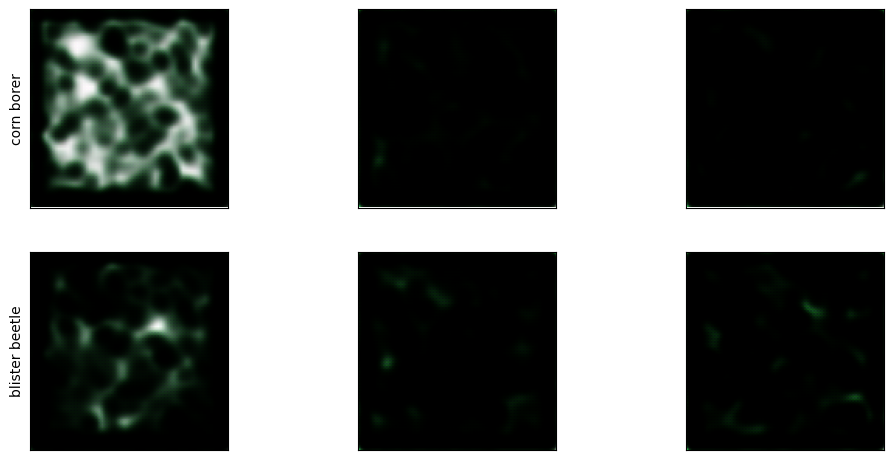

Epoch: 0 -- Generator Loss: 0.6969684362411499, Discriminator Loss: 1.2708051204681396

Took 25.492782592773438 seconds. 


Epoch:  200


56it [00:18,  3.02it/s]


Epoch: 1 -- Generator Loss: 0.6985666155815125, Discriminator Loss: 1.3930385112762451

Took 18.85727572441101 seconds. 


Epoch:  200


56it [00:18,  3.00it/s]


Epoch: 2 -- Generator Loss: 0.6948928833007812, Discriminator Loss: 1.3865464925765991

Took 18.992916345596313 seconds. 


Epoch:  200


56it [00:19,  2.94it/s]


Epoch: 3 -- Generator Loss: 0.6949449181556702, Discriminator Loss: 1.386820912361145

Took 19.383859634399414 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 4 -- Generator Loss: 0.6939941644668579, Discriminator Loss: 1.3866198062896729

Took 19.470040321350098 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 5 -- Generator Loss: 0.6959956288337708, Discriminator Loss: 1.386511206626892

Took 19.39885401725769 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 6 -- Generator Loss: 0.6959938406944275, Discriminator Loss: 1.3864591121673584

Took 19.435649871826172 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 7 -- Generator Loss: 0.6948400139808655, Discriminator Loss: 1.3864132165908813

Took 19.414884567260742 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 8 -- Generator Loss: 0.6953559517860413, Discriminator Loss: 1.385906457901001

Took 19.44100260734558 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 9 -- Generator Loss: 0.6955733895301819, Discriminator Loss: 1.3867501020431519

Took 19.58686327934265 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


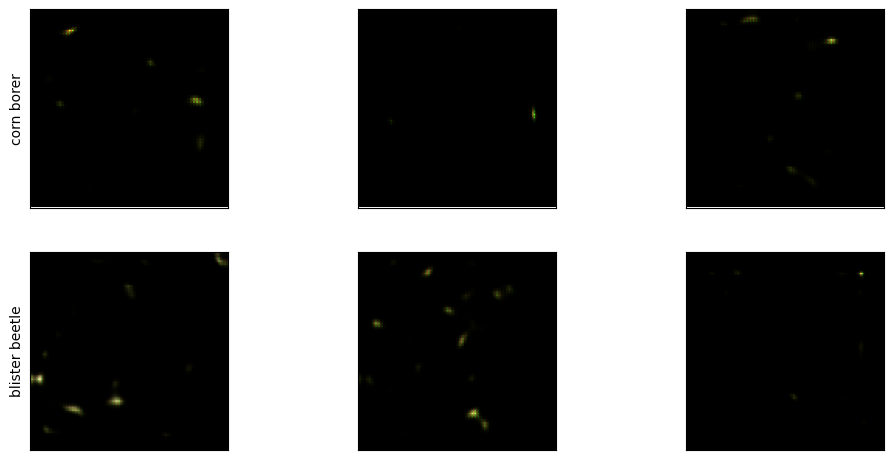

Epoch: 10 -- Generator Loss: 0.6955851316452026, Discriminator Loss: 1.3868032693862915

Took 19.835122108459473 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 11 -- Generator Loss: 0.6956096887588501, Discriminator Loss: 1.3861342668533325

Took 19.480382680892944 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 12 -- Generator Loss: 0.6952099204063416, Discriminator Loss: 1.386492371559143

Took 19.51607036590576 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 13 -- Generator Loss: 0.6952639222145081, Discriminator Loss: 1.3860090970993042

Took 19.503493070602417 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 14 -- Generator Loss: 0.6954678297042847, Discriminator Loss: 1.3860617876052856

Took 19.589303016662598 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 15 -- Generator Loss: 0.6955083012580872, Discriminator Loss: 1.386191725730896

Took 19.51736044883728 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 16 -- Generator Loss: 0.6947369575500488, Discriminator Loss: 1.3868149518966675

Took 19.4343523979187 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 17 -- Generator Loss: 0.6957806348800659, Discriminator Loss: 1.385820984840393

Took 19.5393123626709 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 18 -- Generator Loss: 0.6945198774337769, Discriminator Loss: 1.387332558631897

Took 19.525617122650146 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 19 -- Generator Loss: 0.6952872276306152, Discriminator Loss: 1.3861418962478638

Took 19.587369918823242 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


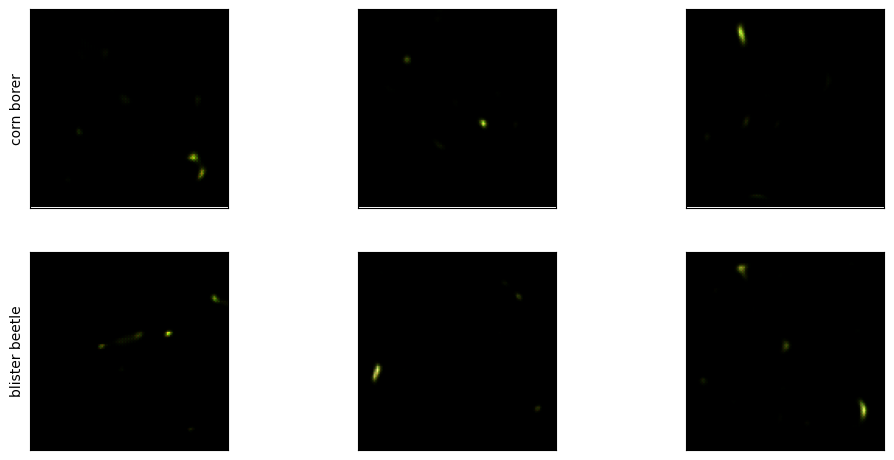

Epoch: 20 -- Generator Loss: 0.6956924796104431, Discriminator Loss: 1.3861585855484009

Took 19.810810327529907 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 21 -- Generator Loss: 0.6953763961791992, Discriminator Loss: 1.3860905170440674

Took 19.56475830078125 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 22 -- Generator Loss: 0.6952981352806091, Discriminator Loss: 1.386190414428711

Took 19.535573482513428 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 23 -- Generator Loss: 0.6951507329940796, Discriminator Loss: 1.3864786624908447

Took 19.563809394836426 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 24 -- Generator Loss: 0.6954489350318909, Discriminator Loss: 1.3857096433639526

Took 19.674512147903442 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 25 -- Generator Loss: 0.6954723000526428, Discriminator Loss: 1.3866264820098877

Took 19.557772397994995 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 26 -- Generator Loss: 0.6948710680007935, Discriminator Loss: 1.3857536315917969

Took 19.567676067352295 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 27 -- Generator Loss: 0.6953815817832947, Discriminator Loss: 1.386871576309204

Took 19.557255506515503 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 28 -- Generator Loss: 0.6953421831130981, Discriminator Loss: 1.3862823247909546

Took 19.619458198547363 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 29 -- Generator Loss: 0.6950292587280273, Discriminator Loss: 1.3864094018936157

Took 19.591899394989014 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


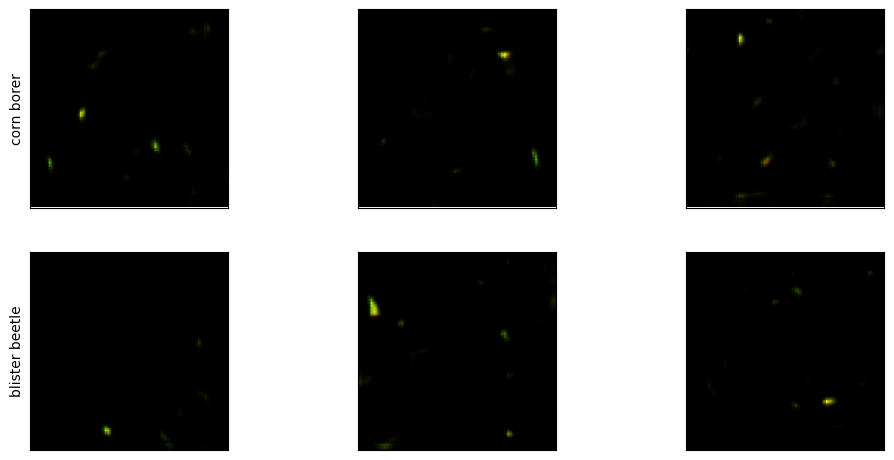

Epoch: 30 -- Generator Loss: 0.6952658891677856, Discriminator Loss: 1.385719895362854

Took 19.88667917251587 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 31 -- Generator Loss: 0.6948650479316711, Discriminator Loss: 1.3860522508621216

Took 19.596747636795044 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 32 -- Generator Loss: 0.6946789622306824, Discriminator Loss: 1.386392593383789

Took 19.633392572402954 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 33 -- Generator Loss: 0.6958536505699158, Discriminator Loss: 1.389121174812317

Took 19.67502737045288 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 34 -- Generator Loss: 0.695800244808197, Discriminator Loss: 1.3863517045974731

Took 19.620532751083374 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 35 -- Generator Loss: 0.6954994201660156, Discriminator Loss: 1.3863451480865479

Took 19.466619729995728 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 36 -- Generator Loss: 0.6962379217147827, Discriminator Loss: 1.387284278869629

Took 19.451478242874146 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 37 -- Generator Loss: 0.695599377155304, Discriminator Loss: 1.38604736328125

Took 19.523159980773926 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 38 -- Generator Loss: 0.6949509382247925, Discriminator Loss: 1.3861846923828125

Took 19.466671228408813 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 39 -- Generator Loss: 0.6949366927146912, Discriminator Loss: 1.3859570026397705

Took 19.589580535888672 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


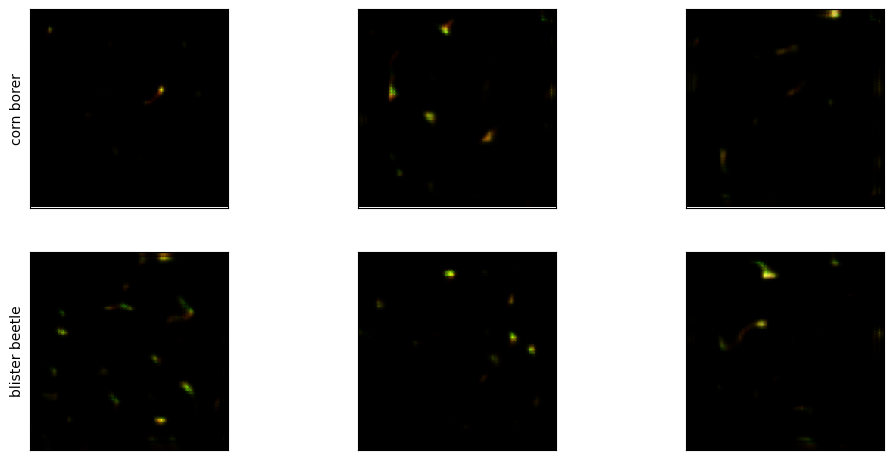

Epoch: 40 -- Generator Loss: 0.6950032114982605, Discriminator Loss: 1.3861043453216553

Took 19.801429748535156 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 41 -- Generator Loss: 0.6950408220291138, Discriminator Loss: 1.3859586715698242

Took 19.409094095230103 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 42 -- Generator Loss: 0.6949690580368042, Discriminator Loss: 1.386139154434204

Took 19.428722143173218 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 43 -- Generator Loss: 0.6952574849128723, Discriminator Loss: 1.3857581615447998

Took 19.565341234207153 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


Epoch: 44 -- Generator Loss: 0.6949073076248169, Discriminator Loss: 1.3856877088546753

Took 19.75959038734436 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 45 -- Generator Loss: 0.6951045989990234, Discriminator Loss: 1.3856974840164185

Took 19.65384316444397 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 46 -- Generator Loss: 0.6949144005775452, Discriminator Loss: 1.386086106300354

Took 19.712230920791626 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 47 -- Generator Loss: 0.6954109072685242, Discriminator Loss: 1.385970115661621

Took 19.712652921676636 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 48 -- Generator Loss: 0.694502055644989, Discriminator Loss: 1.3860828876495361

Took 19.63556456565857 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 49 -- Generator Loss: 0.6954359412193298, Discriminator Loss: 1.3860456943511963

Took 19.613868951797485 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


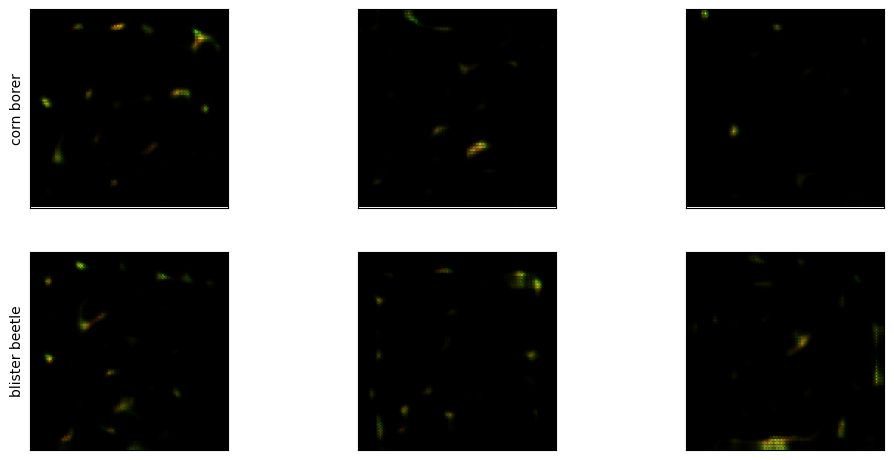

Epoch: 50 -- Generator Loss: 0.6949265599250793, Discriminator Loss: 1.3858636617660522

Took 19.870238065719604 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 51 -- Generator Loss: 0.6950216889381409, Discriminator Loss: 1.386078119277954

Took 19.930181980133057 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 52 -- Generator Loss: 0.6943376660346985, Discriminator Loss: 1.3857587575912476

Took 19.693005800247192 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 53 -- Generator Loss: 0.6954510807991028, Discriminator Loss: 1.3859529495239258

Took 19.62244701385498 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 54 -- Generator Loss: 0.6945610046386719, Discriminator Loss: 1.3857344388961792

Took 19.644516229629517 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 55 -- Generator Loss: 0.6936555504798889, Discriminator Loss: 1.387196660041809

Took 19.62767243385315 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 56 -- Generator Loss: 0.862909734249115, Discriminator Loss: 1.9818699359893799

Took 19.637131214141846 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 57 -- Generator Loss: 0.695622444152832, Discriminator Loss: 1.3871729373931885

Took 19.644331693649292 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 58 -- Generator Loss: 0.6966957449913025, Discriminator Loss: 1.3868920803070068

Took 19.672594785690308 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 59 -- Generator Loss: 0.6962367296218872, Discriminator Loss: 1.3850953578948975

Took 19.682863473892212 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


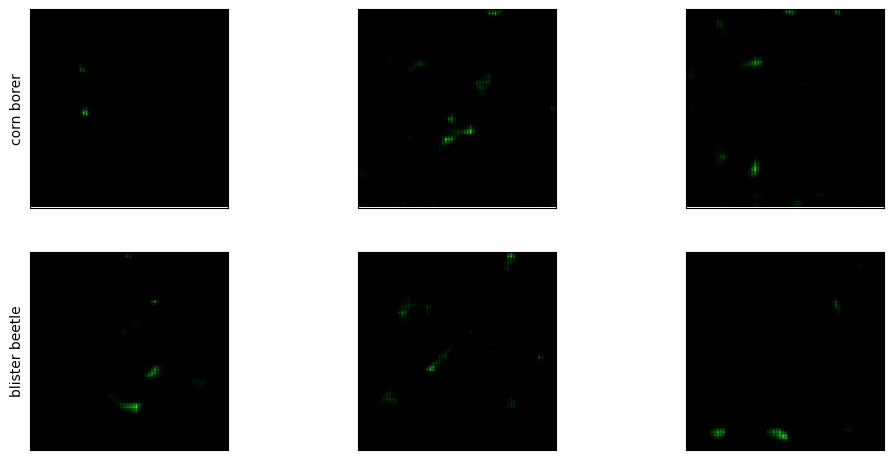

Epoch: 60 -- Generator Loss: 0.6966947913169861, Discriminator Loss: 1.3851803541183472

Took 19.98850679397583 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 61 -- Generator Loss: 0.6965498924255371, Discriminator Loss: 1.385246992111206

Took 19.615764379501343 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 62 -- Generator Loss: 0.6963170766830444, Discriminator Loss: 1.384110450744629

Took 19.6554913520813 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 63 -- Generator Loss: 0.6971705555915833, Discriminator Loss: 1.3850557804107666

Took 19.689950227737427 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 64 -- Generator Loss: 0.6979465484619141, Discriminator Loss: 1.3843183517456055

Took 19.65533185005188 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 65 -- Generator Loss: 0.6966825127601624, Discriminator Loss: 1.3858726024627686

Took 19.665052890777588 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 66 -- Generator Loss: 0.6963708996772766, Discriminator Loss: 1.3829972743988037

Took 19.66969609260559 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 67 -- Generator Loss: 0.6979330778121948, Discriminator Loss: 1.3860538005828857

Took 19.624967098236084 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 68 -- Generator Loss: 0.6968604326248169, Discriminator Loss: 1.38288414478302

Took 19.680761575698853 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 69 -- Generator Loss: 0.69691002368927, Discriminator Loss: 1.3828394412994385

Took 19.715852737426758 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


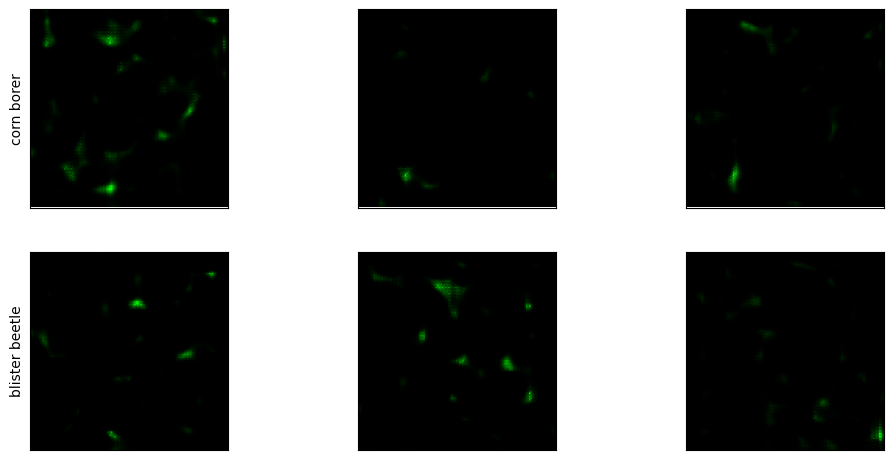

Epoch: 70 -- Generator Loss: 0.6979647278785706, Discriminator Loss: 1.384380578994751

Took 20.02450919151306 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 71 -- Generator Loss: 0.6980417370796204, Discriminator Loss: 1.3831804990768433

Took 19.651247262954712 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


Epoch: 72 -- Generator Loss: 0.6986821293830872, Discriminator Loss: 1.389974594116211

Took 19.74851942062378 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 73 -- Generator Loss: 0.6966341137886047, Discriminator Loss: 1.3822879791259766

Took 19.687823057174683 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


Epoch: 74 -- Generator Loss: 0.6986069083213806, Discriminator Loss: 1.382326364517212

Took 19.767133235931396 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 75 -- Generator Loss: 0.6974865794181824, Discriminator Loss: 1.3830677270889282

Took 19.655248641967773 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 76 -- Generator Loss: 0.6988022923469543, Discriminator Loss: 1.3834478855133057

Took 19.64826536178589 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 77 -- Generator Loss: 0.6994559168815613, Discriminator Loss: 1.3842765092849731

Took 19.614784479141235 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 78 -- Generator Loss: 0.6978740692138672, Discriminator Loss: 1.3802801370620728

Took 19.67564368247986 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 79 -- Generator Loss: 0.7009859085083008, Discriminator Loss: 1.3870220184326172

Took 19.605592727661133 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


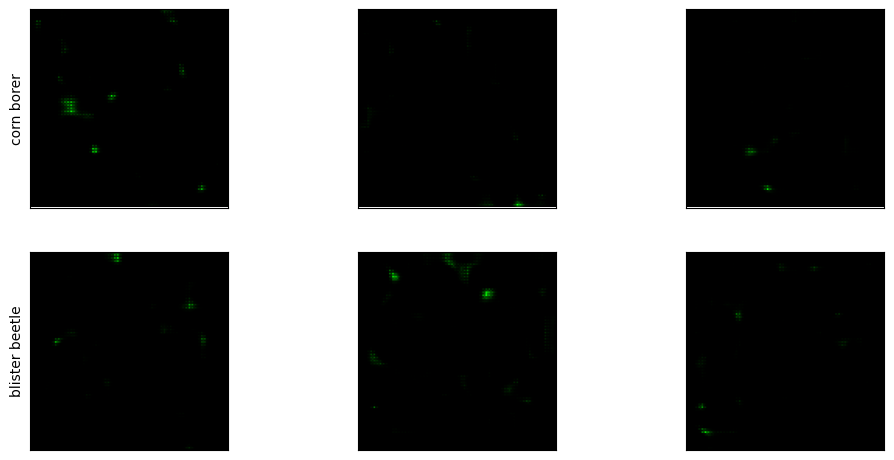

Epoch: 80 -- Generator Loss: 0.6987953186035156, Discriminator Loss: 1.3803834915161133

Took 19.870898485183716 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 81 -- Generator Loss: 0.6999506950378418, Discriminator Loss: 1.3819615840911865

Took 19.577784538269043 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 82 -- Generator Loss: 0.7008996605873108, Discriminator Loss: 1.384192705154419

Took 19.614559412002563 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 83 -- Generator Loss: 0.6985273361206055, Discriminator Loss: 1.3786953687667847

Took 19.70437002182007 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 84 -- Generator Loss: 0.7864416837692261, Discriminator Loss: 1.4489330053329468

Took 19.690350770950317 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 85 -- Generator Loss: 0.6938294172286987, Discriminator Loss: 1.3873876333236694

Took 19.622259616851807 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 86 -- Generator Loss: 0.6938201189041138, Discriminator Loss: 1.3863999843597412

Took 19.550352334976196 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 87 -- Generator Loss: 0.6941990256309509, Discriminator Loss: 1.3858773708343506

Took 19.582319259643555 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 88 -- Generator Loss: 0.69444340467453, Discriminator Loss: 1.38554847240448

Took 19.59691619873047 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 89 -- Generator Loss: 0.6945624947547913, Discriminator Loss: 1.3852769136428833

Took 19.57192349433899 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


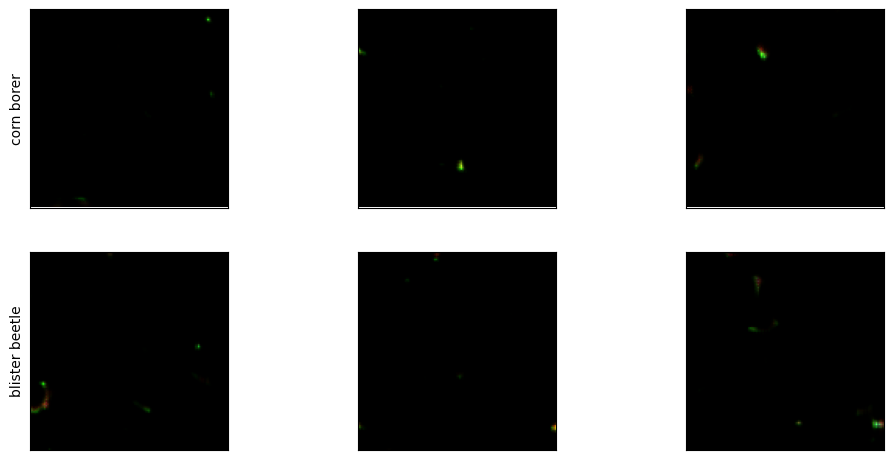

Epoch: 90 -- Generator Loss: 0.6957840919494629, Discriminator Loss: 1.3846713304519653

Took 19.847463846206665 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 91 -- Generator Loss: 0.6961237192153931, Discriminator Loss: 1.3842281103134155

Took 19.55318260192871 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 92 -- Generator Loss: 0.6955720782279968, Discriminator Loss: 1.384822964668274

Took 19.57483458518982 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 93 -- Generator Loss: 0.6956015825271606, Discriminator Loss: 1.3849408626556396

Took 19.614874362945557 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 94 -- Generator Loss: 0.6971555352210999, Discriminator Loss: 1.3853919506072998

Took 19.635174989700317 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 95 -- Generator Loss: 0.6955434679985046, Discriminator Loss: 1.3844553232192993

Took 19.69315481185913 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 96 -- Generator Loss: 0.6960617899894714, Discriminator Loss: 1.3842484951019287

Took 19.692785024642944 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 97 -- Generator Loss: 0.6964894533157349, Discriminator Loss: 1.3841569423675537

Took 19.709615230560303 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 98 -- Generator Loss: 0.6949908137321472, Discriminator Loss: 1.3850634098052979

Took 19.673912286758423 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 99 -- Generator Loss: 0.6957367062568665, Discriminator Loss: 1.384724736213684

Took 19.608726024627686 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


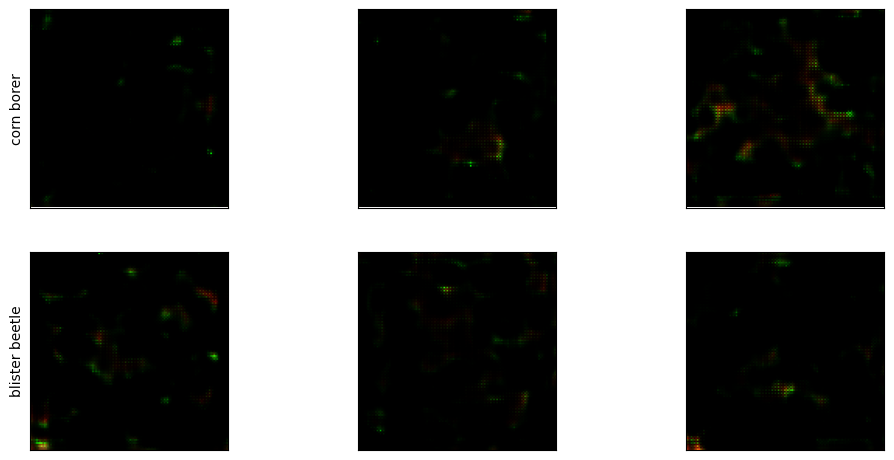

Epoch: 100 -- Generator Loss: 0.6962748765945435, Discriminator Loss: 1.38531494140625

Took 20.002723932266235 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 101 -- Generator Loss: 0.6957506537437439, Discriminator Loss: 1.3847291469573975

Took 19.62184739112854 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 102 -- Generator Loss: 0.6957443952560425, Discriminator Loss: 1.3850606679916382

Took 19.668893098831177 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 103 -- Generator Loss: 0.696025550365448, Discriminator Loss: 1.3849197626113892

Took 19.677191495895386 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 104 -- Generator Loss: 0.6963040232658386, Discriminator Loss: 1.3856031894683838

Took 19.6646990776062 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 105 -- Generator Loss: 0.6957690119743347, Discriminator Loss: 1.3855035305023193

Took 19.673299074172974 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 106 -- Generator Loss: 0.6960784196853638, Discriminator Loss: 1.3865407705307007

Took 19.65415668487549 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 107 -- Generator Loss: 0.6957773566246033, Discriminator Loss: 1.3843382596969604

Took 19.652921676635742 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


Epoch: 108 -- Generator Loss: 0.6957970261573792, Discriminator Loss: 1.384053111076355

Took 19.793325662612915 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 109 -- Generator Loss: 0.6957195997238159, Discriminator Loss: 1.3850454092025757

Took 19.69220280647278 seconds. 


Epoch:  200


56it [00:19,  2.88it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


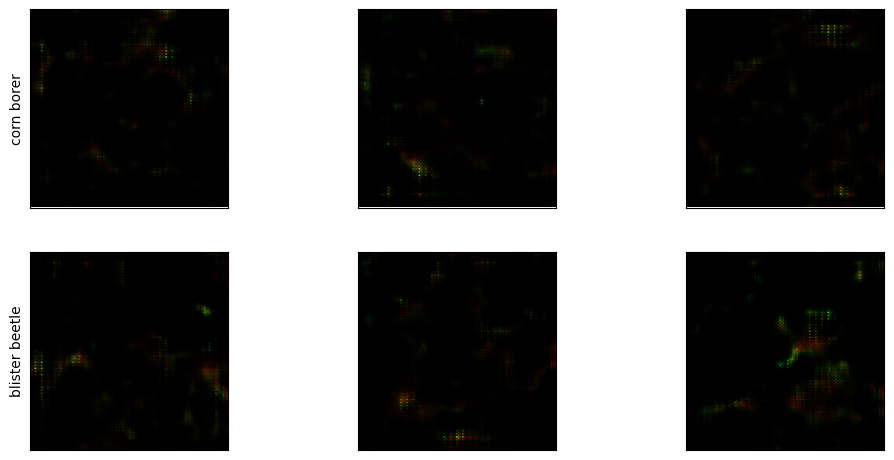

Epoch: 110 -- Generator Loss: 0.6959813833236694, Discriminator Loss: 1.3843168020248413

Took 20.063410758972168 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 111 -- Generator Loss: 0.6972821950912476, Discriminator Loss: 1.3966363668441772

Took 19.73804998397827 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 112 -- Generator Loss: 0.6897794604301453, Discriminator Loss: 1.3872358798980713

Took 19.674060344696045 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 113 -- Generator Loss: 0.690240204334259, Discriminator Loss: 1.3892382383346558

Took 19.750648260116577 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 114 -- Generator Loss: 0.6946076154708862, Discriminator Loss: 1.385854721069336

Took 19.65402579307556 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 115 -- Generator Loss: 0.6936455368995667, Discriminator Loss: 1.3883310556411743

Took 19.742841482162476 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 116 -- Generator Loss: 0.693750262260437, Discriminator Loss: 1.386984944343567

Took 19.706645965576172 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 117 -- Generator Loss: 0.693570077419281, Discriminator Loss: 1.3859825134277344

Took 19.66313886642456 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 118 -- Generator Loss: 0.6931031346321106, Discriminator Loss: 1.3870906829833984

Took 19.592670679092407 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 119 -- Generator Loss: 0.6951813101768494, Discriminator Loss: 1.3862104415893555

Took 19.716256380081177 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


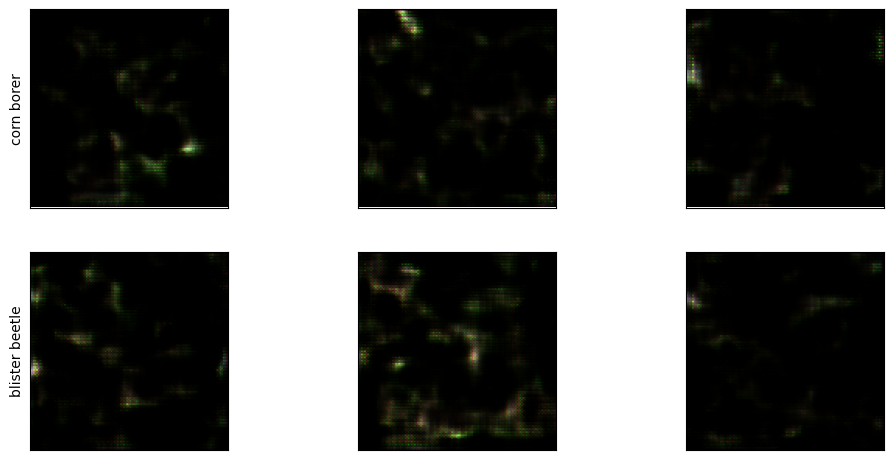

Epoch: 120 -- Generator Loss: 0.6930145621299744, Discriminator Loss: 1.3865057229995728

Took 19.76988196372986 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 121 -- Generator Loss: 0.6937645077705383, Discriminator Loss: 1.3861531019210815

Took 19.542174577713013 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 122 -- Generator Loss: 0.6924155354499817, Discriminator Loss: 1.386470079421997

Took 19.584408283233643 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 123 -- Generator Loss: 0.6931845545768738, Discriminator Loss: 1.3868376016616821

Took 19.592240571975708 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 124 -- Generator Loss: 0.6933830976486206, Discriminator Loss: 1.3864473104476929

Took 19.56002974510193 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 125 -- Generator Loss: 0.6945763826370239, Discriminator Loss: 1.388188362121582

Took 19.65735387802124 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 126 -- Generator Loss: 0.6937964558601379, Discriminator Loss: 1.3881772756576538

Took 19.4827778339386 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 127 -- Generator Loss: 0.6950029730796814, Discriminator Loss: 1.387058973312378

Took 19.68177103996277 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 128 -- Generator Loss: 0.6945149302482605, Discriminator Loss: 1.3873199224472046

Took 19.468244075775146 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 129 -- Generator Loss: 0.6932686567306519, Discriminator Loss: 1.38668954372406

Took 19.435200691223145 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


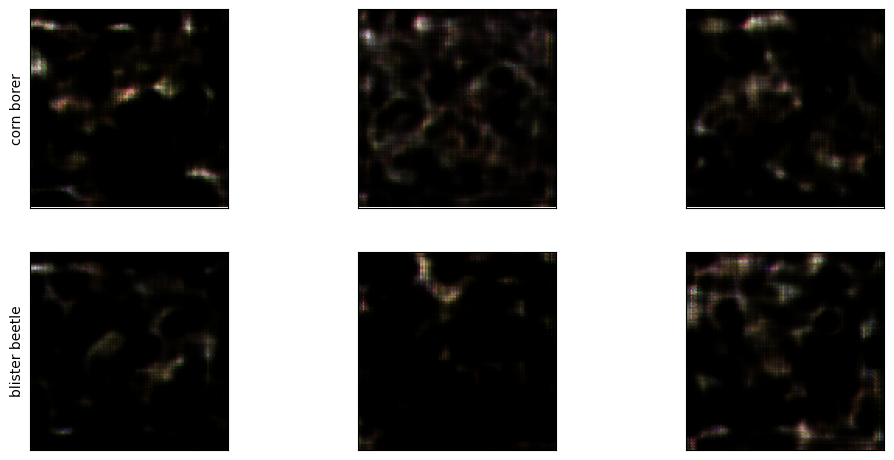

Epoch: 130 -- Generator Loss: 0.6926156282424927, Discriminator Loss: 1.386392593383789

Took 19.827349424362183 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 131 -- Generator Loss: 0.693017303943634, Discriminator Loss: 1.3862487077713013

Took 19.441530466079712 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 132 -- Generator Loss: 0.6930650472640991, Discriminator Loss: 1.386247992515564

Took 19.482939958572388 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 133 -- Generator Loss: 0.6930475234985352, Discriminator Loss: 1.386243224143982

Took 19.4954731464386 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 134 -- Generator Loss: 0.6930772066116333, Discriminator Loss: 1.3861891031265259

Took 19.42537498474121 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 135 -- Generator Loss: 0.6935831904411316, Discriminator Loss: 1.3861300945281982

Took 19.425408840179443 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 136 -- Generator Loss: 0.6932066082954407, Discriminator Loss: 1.386340856552124

Took 19.52014923095703 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 137 -- Generator Loss: 0.6948445439338684, Discriminator Loss: 1.3887284994125366

Took 19.452630281448364 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 138 -- Generator Loss: 0.6934372782707214, Discriminator Loss: 1.3861967325210571

Took 19.497093677520752 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 139 -- Generator Loss: 0.6932750344276428, Discriminator Loss: 1.3864002227783203

Took 19.62852430343628 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


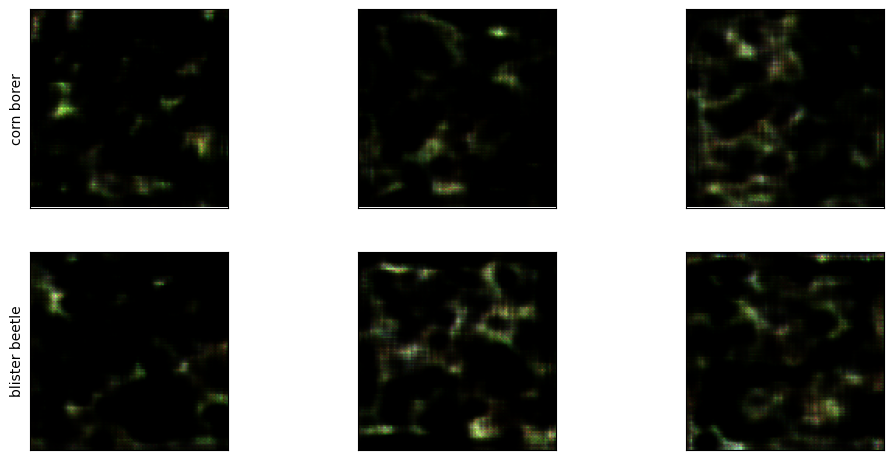

Epoch: 140 -- Generator Loss: 0.6937544941902161, Discriminator Loss: 1.3862038850784302

Took 19.789957523345947 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 141 -- Generator Loss: 0.6926924586296082, Discriminator Loss: 1.3863612413406372

Took 19.40755033493042 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 142 -- Generator Loss: 0.693328857421875, Discriminator Loss: 1.3863540887832642

Took 19.45419692993164 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 143 -- Generator Loss: 0.692990243434906, Discriminator Loss: 1.3863364458084106

Took 19.4925799369812 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 144 -- Generator Loss: 0.6930865049362183, Discriminator Loss: 1.3863509893417358

Took 19.588881731033325 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 145 -- Generator Loss: 0.693160891532898, Discriminator Loss: 1.386361002922058

Took 19.55123209953308 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 146 -- Generator Loss: 0.693260133266449, Discriminator Loss: 1.3863493204116821

Took 19.511519193649292 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 147 -- Generator Loss: 0.6932382583618164, Discriminator Loss: 1.386344075202942

Took 19.60573720932007 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 148 -- Generator Loss: 0.6930302381515503, Discriminator Loss: 1.3863756656646729

Took 19.642364740371704 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 149 -- Generator Loss: 0.6929230093955994, Discriminator Loss: 1.386502981185913

Took 19.58892798423767 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


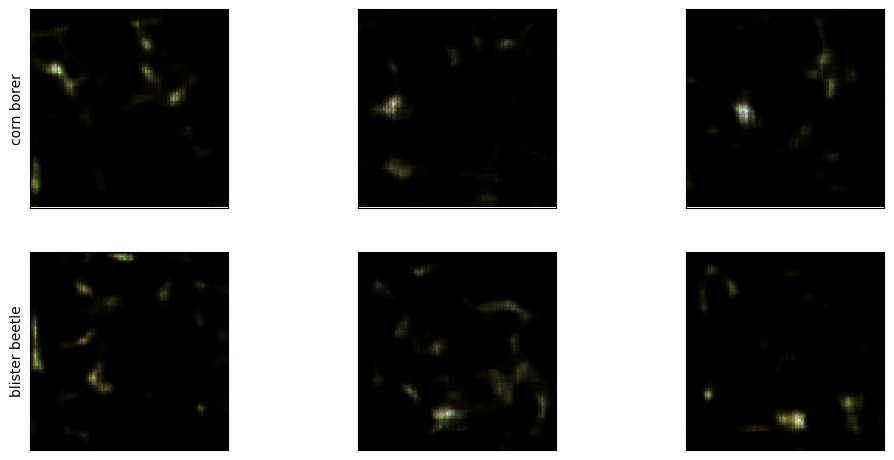

Epoch: 150 -- Generator Loss: 0.6953507661819458, Discriminator Loss: 1.3868476152420044

Took 19.80797004699707 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 151 -- Generator Loss: 0.6930080056190491, Discriminator Loss: 1.3865946531295776

Took 19.60430908203125 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 152 -- Generator Loss: 0.6946120858192444, Discriminator Loss: 1.3876692056655884

Took 19.595534563064575 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 153 -- Generator Loss: 0.6936129331588745, Discriminator Loss: 1.3866045475006104

Took 19.50912380218506 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 154 -- Generator Loss: 0.6932120323181152, Discriminator Loss: 1.3867729902267456

Took 19.559566974639893 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 155 -- Generator Loss: 0.695037305355072, Discriminator Loss: 1.3872860670089722

Took 19.543400526046753 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 156 -- Generator Loss: 0.6948994398117065, Discriminator Loss: 1.3864898681640625

Took 19.52461886405945 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 157 -- Generator Loss: 0.6931690573692322, Discriminator Loss: 1.3868755102157593

Took 19.589816093444824 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 158 -- Generator Loss: 0.693465530872345, Discriminator Loss: 1.3864375352859497

Took 19.526450395584106 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 159 -- Generator Loss: 0.6941937208175659, Discriminator Loss: 1.3867806196212769

Took 19.66113543510437 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


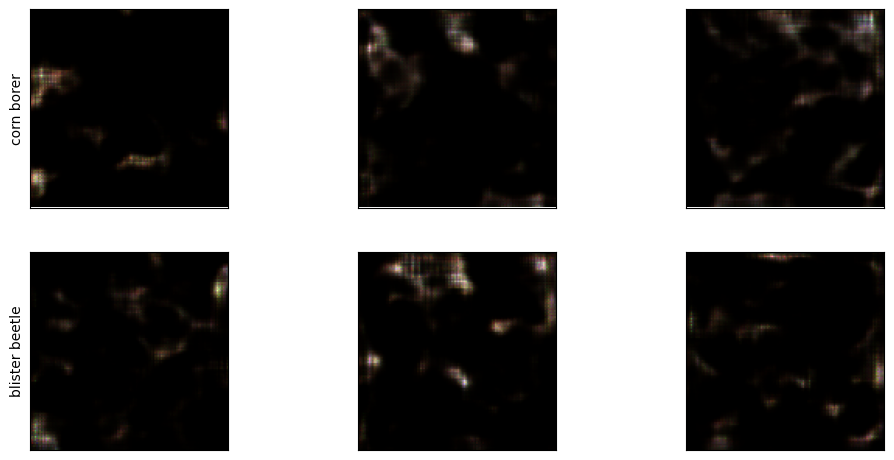

Epoch: 160 -- Generator Loss: 0.6930431127548218, Discriminator Loss: 1.3863691091537476

Took 19.87401533126831 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 161 -- Generator Loss: 0.6931036710739136, Discriminator Loss: 1.386526346206665

Took 19.51606011390686 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 162 -- Generator Loss: 0.6938071846961975, Discriminator Loss: 1.3864593505859375

Took 19.58246874809265 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 163 -- Generator Loss: 0.6932610273361206, Discriminator Loss: 1.38631272315979

Took 19.6956627368927 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 164 -- Generator Loss: 0.6935127973556519, Discriminator Loss: 1.3865896463394165

Took 19.647116899490356 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 165 -- Generator Loss: 0.6936281323432922, Discriminator Loss: 1.3865890502929688

Took 19.574331998825073 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 166 -- Generator Loss: 0.6933649778366089, Discriminator Loss: 1.3864778280258179

Took 19.604435205459595 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 167 -- Generator Loss: 0.6934906840324402, Discriminator Loss: 1.3867759704589844

Took 19.5364727973938 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 168 -- Generator Loss: 0.6938537359237671, Discriminator Loss: 1.38633131980896

Took 19.52254366874695 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 169 -- Generator Loss: 0.6947503685951233, Discriminator Loss: 1.3865643739700317

Took 19.5292751789093 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


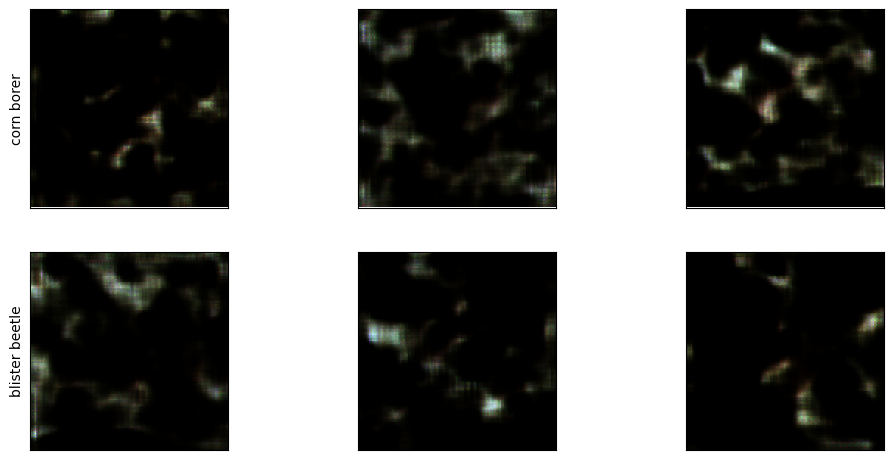

Epoch: 170 -- Generator Loss: 0.6933491826057434, Discriminator Loss: 1.3864084482192993

Took 19.800920724868774 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 171 -- Generator Loss: 0.6928791403770447, Discriminator Loss: 1.3862465620040894

Took 19.451946258544922 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 172 -- Generator Loss: 0.6934424638748169, Discriminator Loss: 1.386189341545105

Took 19.420380115509033 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 173 -- Generator Loss: 0.6930943727493286, Discriminator Loss: 1.3862847089767456

Took 19.536163091659546 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 174 -- Generator Loss: 0.695508599281311, Discriminator Loss: 1.3878109455108643

Took 19.48870277404785 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 175 -- Generator Loss: 0.6932177543640137, Discriminator Loss: 1.3865859508514404

Took 19.48247265815735 seconds. 


Epoch:  200


56it [00:19,  2.93it/s]


Epoch: 176 -- Generator Loss: 0.6934581398963928, Discriminator Loss: 1.3864606618881226

Took 19.42691731452942 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 177 -- Generator Loss: 0.6938194036483765, Discriminator Loss: 1.3871477842330933

Took 19.511040925979614 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 178 -- Generator Loss: 0.6926441788673401, Discriminator Loss: 1.3862673044204712

Took 19.563234329223633 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 179 -- Generator Loss: 0.6928439736366272, Discriminator Loss: 1.3863298892974854

Took 19.681029319763184 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


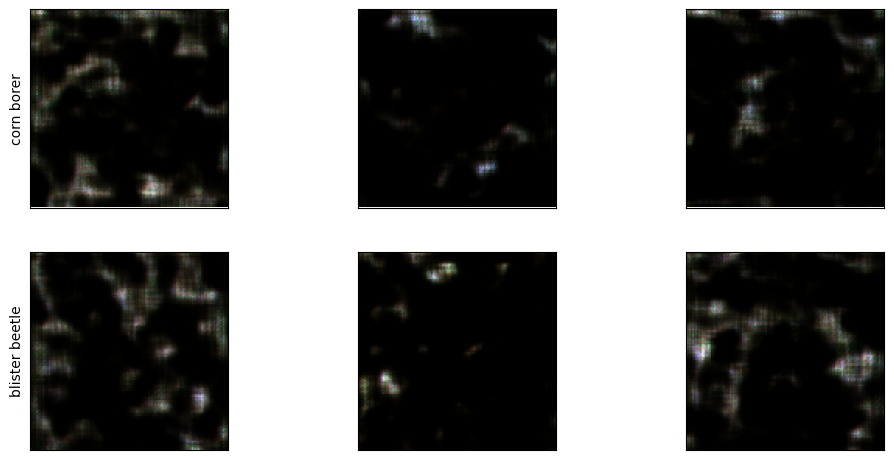

Epoch: 180 -- Generator Loss: 0.6931565403938293, Discriminator Loss: 1.3863353729248047

Took 19.842959880828857 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 181 -- Generator Loss: 0.693027675151825, Discriminator Loss: 1.3862806558609009

Took 19.506467580795288 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 182 -- Generator Loss: 0.693050742149353, Discriminator Loss: 1.3863343000411987

Took 19.563633680343628 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 183 -- Generator Loss: 0.6933282017707825, Discriminator Loss: 1.3862838745117188

Took 19.634533166885376 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 184 -- Generator Loss: 0.6933069229125977, Discriminator Loss: 1.386290431022644

Took 19.633231163024902 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 185 -- Generator Loss: 0.6932287812232971, Discriminator Loss: 1.3862855434417725

Took 19.538142204284668 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 186 -- Generator Loss: 0.6928625702857971, Discriminator Loss: 1.3863122463226318

Took 19.686654329299927 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 187 -- Generator Loss: 0.6931011080741882, Discriminator Loss: 1.386337399482727

Took 19.643338203430176 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 188 -- Generator Loss: 0.6931813955307007, Discriminator Loss: 1.3863489627838135

Took 19.51324963569641 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 189 -- Generator Loss: 0.6930743455886841, Discriminator Loss: 1.3863452672958374

Took 19.585237979888916 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


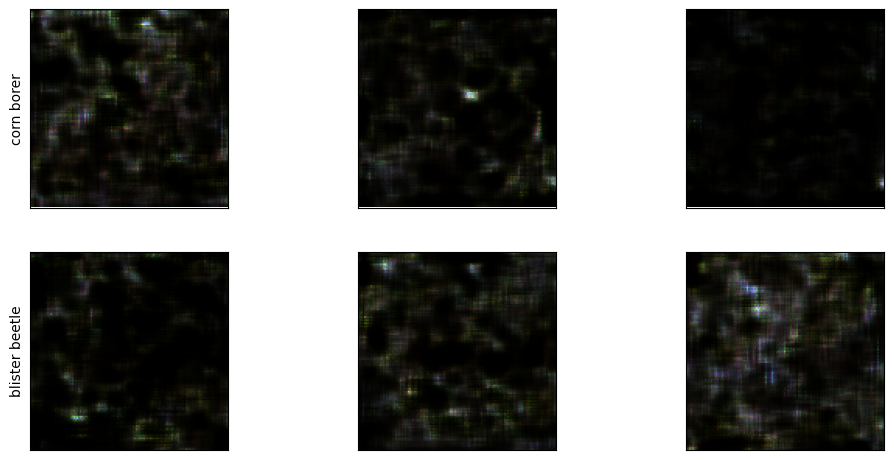

Epoch: 190 -- Generator Loss: 0.6930544972419739, Discriminator Loss: 1.3863574266433716

Took 20.172226667404175 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 191 -- Generator Loss: 0.6932061314582825, Discriminator Loss: 1.3863849639892578

Took 19.485474824905396 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 192 -- Generator Loss: 0.6930163502693176, Discriminator Loss: 1.3863989114761353

Took 19.49040961265564 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 193 -- Generator Loss: 0.6931008100509644, Discriminator Loss: 1.386423110961914

Took 19.51902198791504 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 194 -- Generator Loss: 0.6932052969932556, Discriminator Loss: 1.3863866329193115

Took 19.629449367523193 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 195 -- Generator Loss: 0.6931143999099731, Discriminator Loss: 1.3863755464553833

Took 19.57136297225952 seconds. 


Epoch:  200


56it [00:19,  2.91it/s]


Epoch: 196 -- Generator Loss: 0.6931995749473572, Discriminator Loss: 1.386371374130249

Took 19.576760292053223 seconds. 


Epoch:  200


56it [00:19,  2.92it/s]


Epoch: 197 -- Generator Loss: 0.69373619556427, Discriminator Loss: 1.3865013122558594

Took 19.51011323928833 seconds. 


Epoch:  200


56it [00:19,  2.89it/s]


Epoch: 198 -- Generator Loss: 0.6952624917030334, Discriminator Loss: 1.3886724710464478

Took 19.76071524620056 seconds. 


Epoch:  200


56it [00:19,  2.90it/s]


Epoch: 199 -- Generator Loss: 0.6936255097389221, Discriminator Loss: 1.3864963054656982

Took 19.63171648979187 seconds. 




In [22]:
def train(dataset, epochs=epoch_count):

    for epoch in range(epochs):
        print('Epoch: ', epochs)
        d_loss_list = []
        g_loss_list = []
        q_loss_list = []
        start = time.time()
        
        itern = 0
        for image_batch in tqdm(dataset):
            real_images, real_labels = image_batch
            d_loss, g_loss = train_step(image_batch)
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)
            itern=itern+1
        if epoch % 10 == 0:
            show_samples(3, n_class, g_model)
            
        print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n')


dic = f"GAN_result/{str(datetime.datetime.today())}"
os.mkdir(dic)
basic_info = {"batch_size": batch_size, "image_size":img_size, "epoch": epoch_count, "noise_dim":noise_dim, "n_class":n_class}

keys = basic_info.keys()
rows = basic_info.values()

with open(f"{dic}/basic_info.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(keys)
    writer.writerows([rows])


train(dataset, epochs=epoch_count)

g_model.save(f"{dic}/generator.keras")
d_model.save(f"{dic}/discriminator.keras")   